# FigureOneLabs: Proper acquisition of cell class identity in organoids allows definition of fate specification programs of the human cerebral cortex (Uzquiano, 2022)
## Recreating figure one

In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import anndata
import scanpy as sc
import pybiomart
import scvi
import torch
import random
import seaborn as sns

Create a function, `PlotUMAP`, that creates a UMAP plot for each marker in the provided `markers` list. The function takes several parameters:
* `adata`: an AnnData object.
* `markers`: a list of markers (genes) to be visualised on the UMAP plot.
* `layer`: specifies the layer of data to use, with a default value of `log2_counts_scvi`.
* `size`: sets the size of the points in the plot.
* `vmin` and `vmax`: set the minimum and maximum values for the colour scale.

In [2]:
def PlotUMAP(adata, markers, layer='log2_counts_scvi', size=2, vmin='p0', vmax='p99'):
    # Loop over each marker in the markers list
    for i in range(len(markers)):
        # Within the loop, the umap function of the from the scanpy.plotting module (sc.pl) is called for each marker
        sc.pl.umap(adata, # The AnnData object to be plotted
                  color=markers[i], # Colours the UMAP plot points according to the expression of the current marker
                  layer=layer, # Layer of data for the plot
                  size=size, # Size of points in the plot
                  cmap=sns.blend_palette(['lightgray', sns.xkcd_rgb['red orange']], as_cmap=True), # Colourmap for the plot
                   vmin=vmin, vmax=vmax) # Minimum and maximum values for the colour scale

Read in the previously created AnnData object.

In [3]:
adata = sc.read_h5ad('./outs/231228_uzquiano_d23_rna_scvi.h5ad')
adata

AnnData object with n_obs × n_vars = 29736 × 20589
    obs: 'CellID', 'SampleID', 'donor_id', 'nGene', 'nUMI', 'sex', 'library_preparation_protocol__ontology_label', 'biosample_type', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden_scvi'
    var: 'Genes', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden_scvi', 'leiden_scvi_colors', 'neighbors_scvi', 'umap'
    obsm: 'X_scvi', 'X_umap'
    layers: 'counts', 'counts_scvi'
    obsp: 'neighbors_scvi_connectivities', 'neighbors_scvi_distances'

Log transform the `counts` and `counts_scvi` layers.

*Notes:*
* In scRNA-seq data, gene expression values can have a large dynamic range - the log transformation helps to reduce skewness and make the data more amenable to analysis.
* The logarithm base 2 of a number y is the power to which the base 2 must be raised to obtain the number y.
* Before applying the logarthim, 1 is added to x to ensure that the argument of the logarithm is always positive, even is x is 0 or a small positive number.
* Taking the logarithm of (1 + x) helps to stabilise the variance of the data, especially in cases when x can span several orders of magnitude (such as RNA-seq counts).
* Log transformation compresses the range of data and can make it more normally distibuted.

In [4]:
# Log transform the counts_scvi layer and assign it to a new layer of the AnnData object, log2_counts
# sc.pp.log1p() performs a log1p transformation (logarithm of one plus the input) from the scanpy preprocessing module (sc.pp)
# adata.layers['counts'].copy makes a copy of the counts layer to avoid modifying the original data
# base=2 specifies the base of the logarithm to be 2 - the log1p function will compute the log base 2 of (1 + x) for each element x in the copied counts layer
adata.layers['log2_counts'] = sc.pp.log1p(adata.layers['counts'].copy(), base=2)
# Log transform the counts_scvi layer and assign it to a new layer of the AnnData object, log2_counts_scvi
adata.layers['log2_counts_scvi'] = sc.pp.log1p(adata.layers['counts_scvi'].copy(), base=2)

Two new layers were created in the AnnData object `adata`:
* `log2_counts`: contains the log base 2 transformed values of the `counts` layer.
* `log2_counts_scvi`: contains the log base 2 transformed values of the `counts_scvi` layer.

Create a UMAP plot of the data in the `adata` object, colouring the data points according the `leiden_scvi` clustering results. The Leiden algorithm is used for community detection in networks, often applied to clustering cells in scRNA-seq data. This plot helps to understand how cells are grouped based on their expression profiles and how these groups are distributed in the reduced dimensional space provided by UMAP.

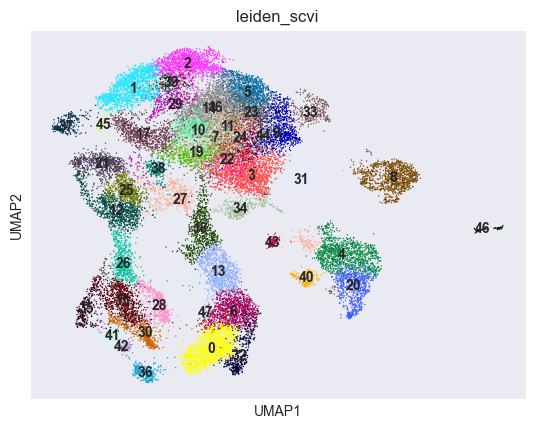

In [5]:
sc.pl.umap(adata, color=['leiden_scvi'], legend_loc='on data')

In [6]:
adata.obs

,CellID,SampleID,donor_id,nGene,nUMI,sex,library_preparation_protocol__ontology_label,biosample_type,n_genes,_scvi_batch,_scvi_labels,leiden_scvi
0,1_AAACGAACACGTGAGA-1_1_23d,Org1,Mito 210 c1 b1,536,3724,male,10X sequencing,DerivedType_Organoid,536,0,0,38
1,1_AAACGAAGTCGAAACG-1_1_23d,Org1,Mito 210 c1 b1,2310,9184,male,10X sequencing,DerivedType_Organoid,2310,0,0,14
2,1_AAACGAAGTGGCAGAT-1_1_23d,Org1,Mito 210 c1 b1,2070,6359,male,10X sequencing,DerivedType_Organoid,2068,0,0,35
3,1_AAACGAAGTGGTTCTA-1_1_23d,Org1,Mito 210 c1 b1,1292,3468,male,10X sequencing,DerivedType_Organoid,1291,0,0,26
4,1_AAACGAAGTTGGCCGT-1_1_23d,Org1,Mito 210 c1 b1,832,1809,male,10X sequencing,DerivedType_Organoid,831,0,0,15
...,...,...,...,...,...,...,...,...,...,...,...,...
29731,3_TTTGGTTTCGGAATGG-1_2_23d,Org6,PGP1 c1 b2,995,1825,male,10X sequencing,DerivedType_Organoid,994,5,0,13
29732,3_TTTGGTTTCGGTTAGT-1_2_23d,Org6,PGP1 c1 b2,3449,13964,male,10X sequencing,DerivedType_Organoid,3449,5,0,1
29733,3_TTTGTTGAGACCATAA-1_2_23d,Org6,PGP1 c1 b2,1382,3670,male,10X sequencing,DerivedType_Organoid,1382,5,0,9
29734,3_TTTGTTGAGAGAAGGT-1_2_23d,Org6,PGP1 c1 b2,1331,3713,male,10X sequencing,DerivedType_Organoid,1329,5,0,11


Create a UMAP plot of the data in the `adata` object, colouring the data points according the `SampleID` metadata. Each point (representing a cell) will be coloured based on which sample it belongs to. This plot helps to understand how cells from different samples are distributed in the reduced dimensional space provided by UMAP, and whether there are distinct clusters or overlap between samples.

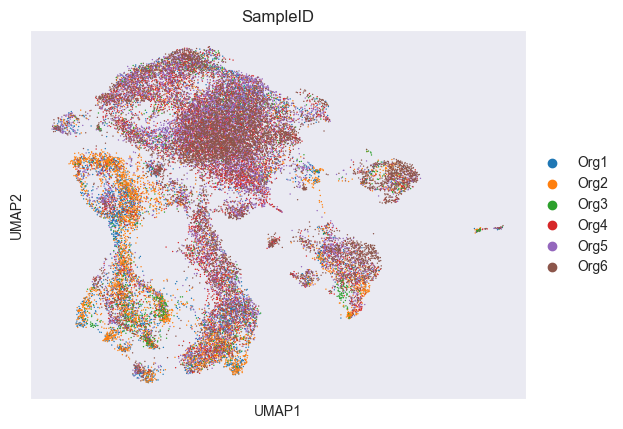

In [7]:
sc.pl.umap(adata, color=['SampleID'])

Update the variable names (gene identifiers) in `adata` to the values found in the `Genes` column of the `adata.var` dataframe.

In [8]:
# adata.var_names is an attribute of the AnnData object that contains the names of the variables in the dataset - it is a list/index object that holds the identifiers for each gene
# adata.var['Genes'] accesses the Genes column in the adata.var dataframe
adata.var_names = adata.var['Genes']

Generate a dotplot, showing the expression levels of each gene marker in the `markers` list across different clusters identified by Leiden clustering. Create a UMAP plot for each gene marker, using the `log2_counts_scvi` layer. These plots help in understanding the expression patterns of specific genes across different cell clusters and in a reduced dimensional space, providing insights into cell type-specific expression profiles and potential biological functions.

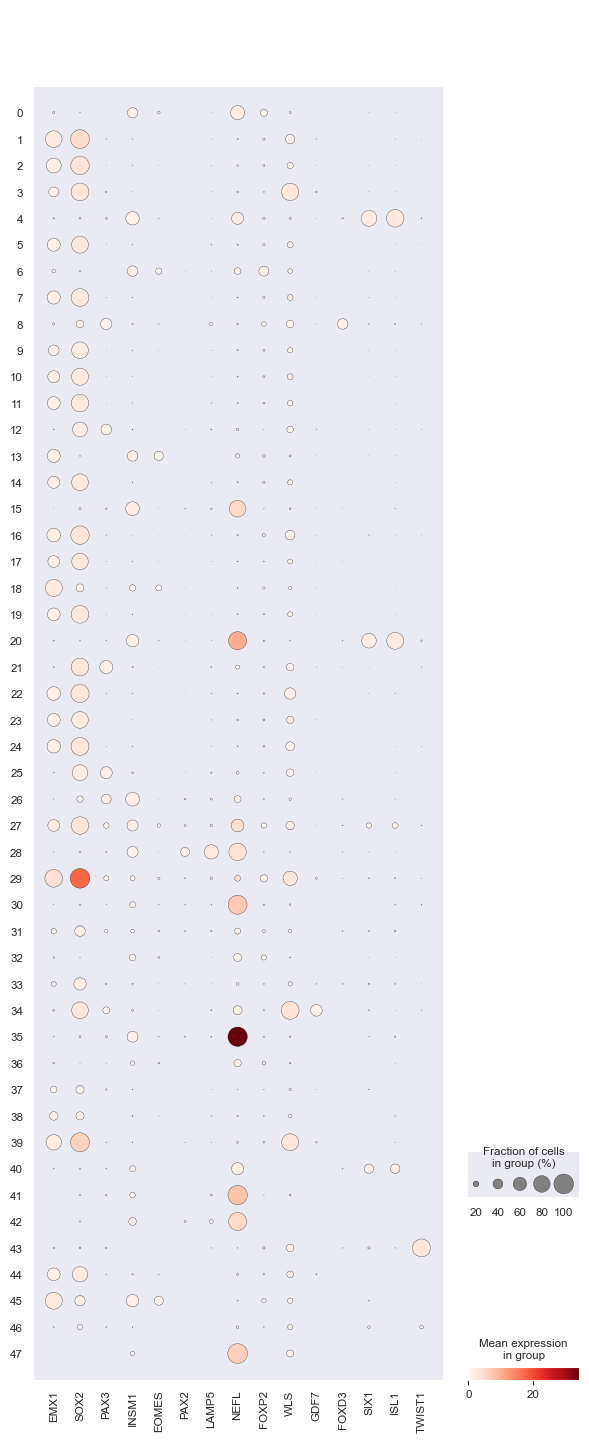

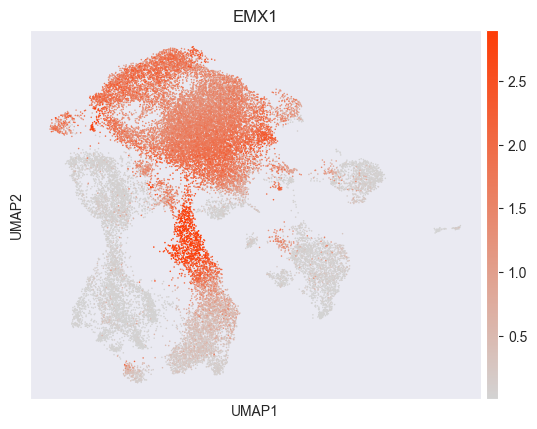

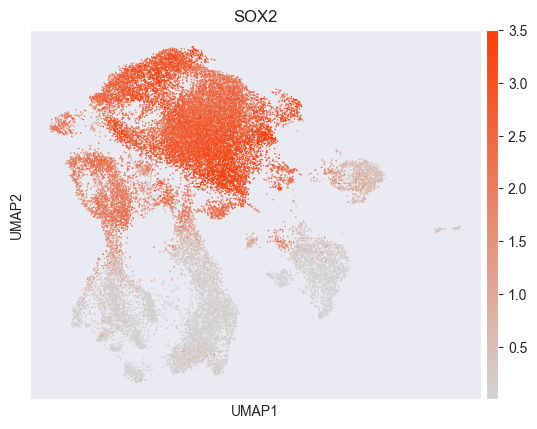

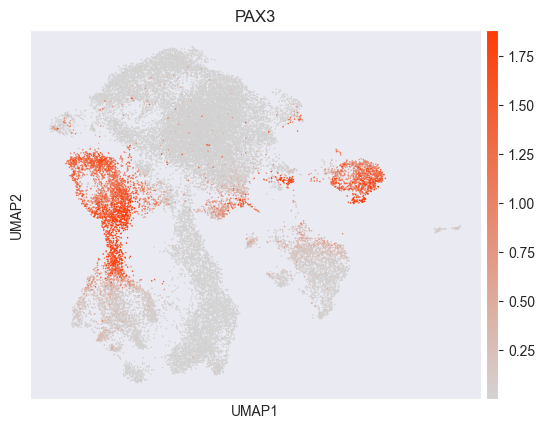

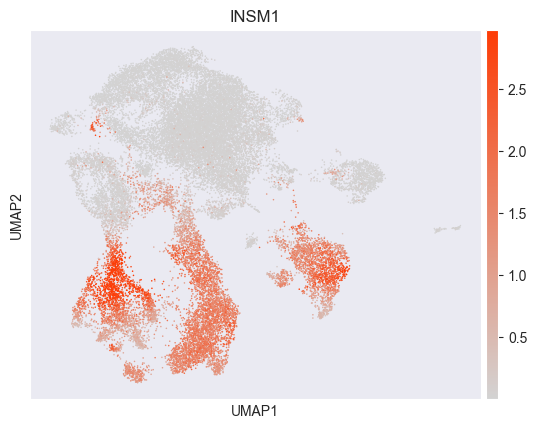

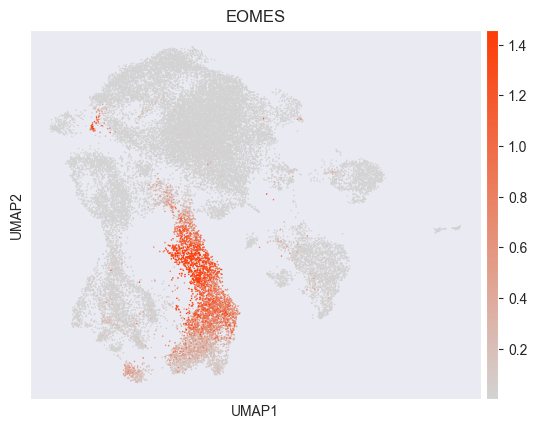

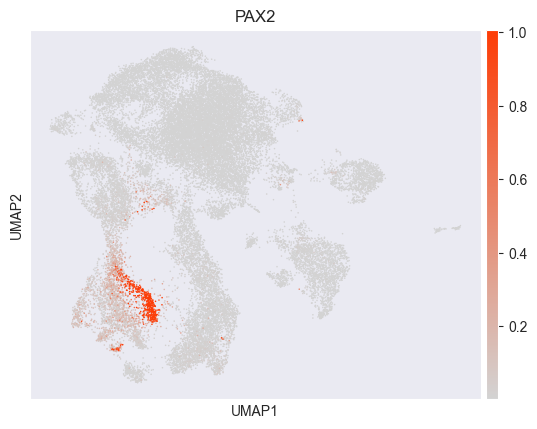

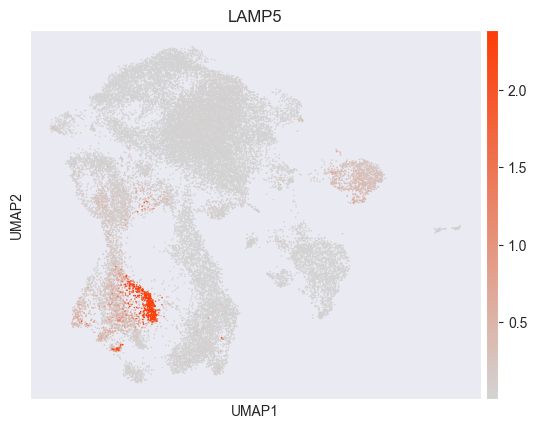

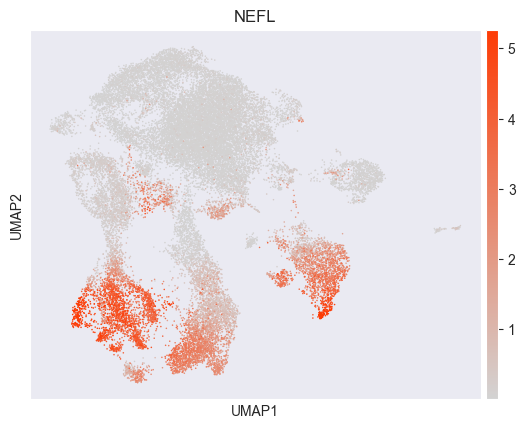

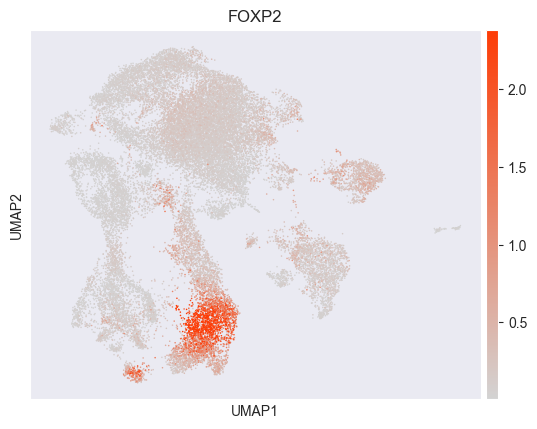

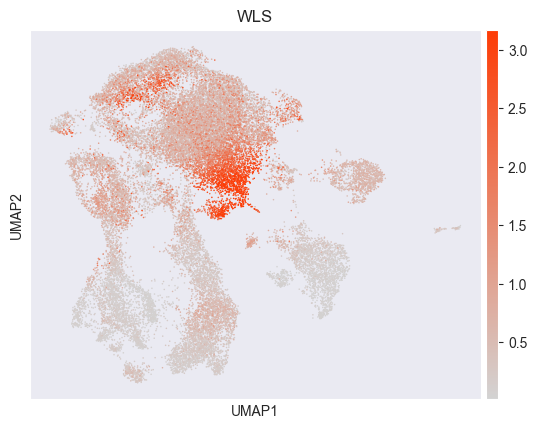

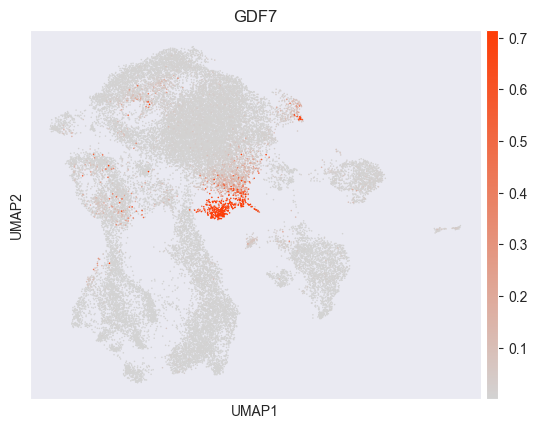

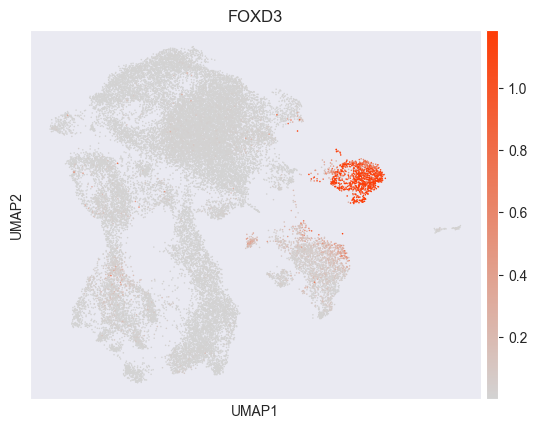

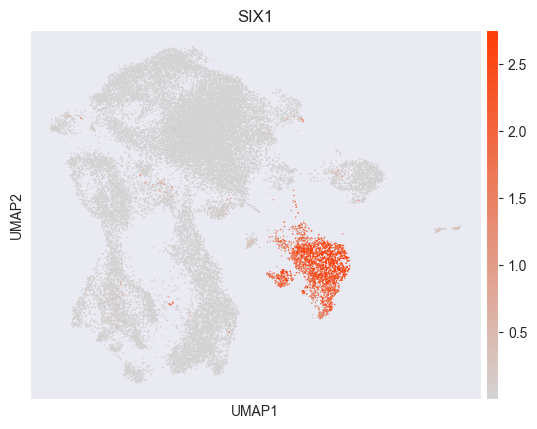

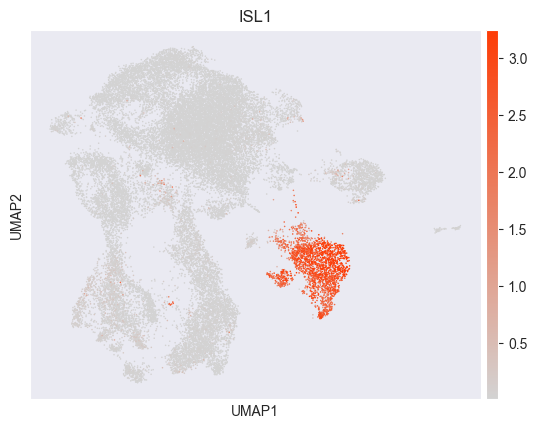

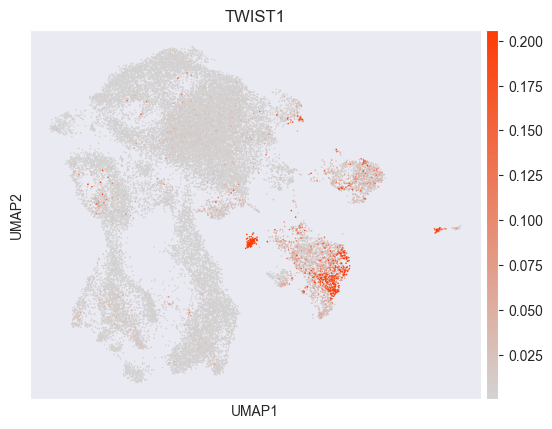

In [9]:
# Dataset1-MarkerGeneExpression.tif

# List of gene markers - each element in the list is a gene identifier
markers = ['EMX1','SOX2','PAX3','INSM1','EOMES',
           'PAX2','LAMP5','NEFL','FOXP2','WLS',
           'GDF7','FOXD3','SIX1','ISL1','TWIST1']
# Create a dotplot showing the expression of multiple genes across different clusters
# groupby="leiden_scvi" specifies how to group the data for the dotplot - each cluster will be represented as a separate group in the dot plot
sc.pl.dotplot(adata, markers, groupby='leiden_scvi')
# Use the PlotUMAP function to create a UMAP plot for each marker gene
PlotUMAP(adata, markers, layer='log2_counts_scvi', size=5)

Assign cluster identifiers to cell type labels and create a UMAP plot using the cell type labels. This plot helps to visualise the distribution of different cell tupes in the reduced dimensional space.

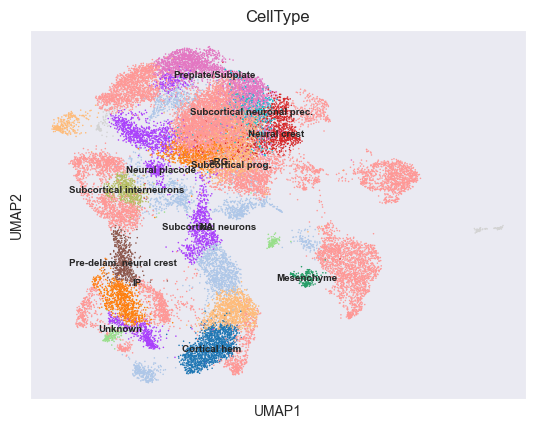

In [10]:
# aRG: 1, 3, 4, 7, 8, 10, 11, 12, 14, 16, 20, 21, 28, 31, 32, 33, 35, 42
# IP: 15, 19
# Preplate/Subplate: 2, 5, 44
# Cortical hem: 0
# Subcortical prog.: 6, 22, 24, 37
# Subcortical neuronal prec.: 23
# Subcortical neurons: 13, 27, 29, 34, 36
# Subcortical interneurons: 25
# Pre-delam. neural crest: 26
# Neural crest: 9
# Neural placode: 17, 18, 30, 38?, 39
# Mesenchyme: 40
# Unknown: 41, 43

# Create a dictionary that maps cluster identifiers to their corresponding cell type labels.
cluster_labels = {'0':'Cortical hem',
                  '1':'aRG',
                  '2':'Preplate/Subplate',
                  '3':'aRG',
                  '4':'aRG',
                  '5':'Preplate/Subplate',
                  '6':'Subcortical prog.',
                  '7':'aRG',
                  '8':'aRG',
                  '9':'Neural crest',
                  '10':'aRG',
                  '11':'aRG',
                  '12':'aRG',
                  '13':'Subcortical neurons',
                  '14':'aRG',
                  '15':'IP',
                  '16':'aRG',
                  '17':'Neural placode',
                  '18':'Neural placode',
                  '19':'IP',
                  '20':'aRG',
                  '21':'aRG',
                  '22':'Subcortical prog.',
                  '23':'Subcortical neuronal prec.',
                  '24':'Subcortical prog.',
                  '25':'Subcortical interneurons',
                  '26':'Pre-delam. neural crest',
                  '27':'Subcortical neurons',
                  '28':'aRG',
                  '29':'Subcortical neurons',
                  '30':'Neural placode',
                  '31':'aRG',
                  '32':'aRG',
                  '33':'aRG',
                  '34':'Subcortical neurons',
                  '35':'aRG',
                  '36':'Subcortical neurons',
                  '37':'Subcortical prog.',
                  '38':'Neural placode',
                  '39':'Neural placode',
                  '40':'Mesenchyme',
                  '41':'Unknown',
                  '42':'aRG',
                  '43':'Unknown',
                  '44':'Preplate/Subplate'}
# Create a new column, CellType, is the AnnData object and map the cluster identifiers (in leiden_scvi column) to the corresponding cell type labels (in the cluster_labels dictionary)
adata.obs['CellType'] = adata.obs['leiden_scvi'].map(cluster_labels)
# Create a UMAP plot, colouring the points according to the CellType column
sc.pl.umap(adata, color=['CellType'], size=5, legend_loc='on data', legend_fontsize=7)

Example workflow for assigning cell type labels to cluster identifiers:
* **Clustering**:
    * Cells are grouped into clusters based on the expression profiles using algorithms like Leiden, Louvain, or k-means.
* **Identify marker genes**:
    * Identify differentially expressed genes for each cluster.
* **Annotation tools:**
    * Run automated tools to get preliminary cell type labels - there are several tools that can automatically assign cell type labels based on marker gene expression:
        * SingleR: compares the scRNA-seq data to reference datasets.
        * Garnett: uses a classifier trainer on known cell types.
        * CellAssign: uses a probabilistic model to assign cell types based on marker genes.
* **Manual refinement:**
    * Inspect marker gene expression manually and adjust labels based on literature and knowledge.
* **Validation:**
    * Cross-check annotations using independent datasets or experiments.